In [63]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from datetime import datetime

In [64]:
# Ticker symbol for S&P 500 index
ticker_symbol = '^GSPC'

# Fetch historical data
sp500_data = yf.download(ticker_symbol, start='1900-01-01', end='2023-12-31')

# Display the fetched data
print(sp500_data)

[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close    Adj Close  \
Date                                                                          
1927-12-30    17.660000    17.660000    17.660000    17.660000    17.660000   
1928-01-03    17.760000    17.760000    17.760000    17.760000    17.760000   
1928-01-04    17.719999    17.719999    17.719999    17.719999    17.719999   
1928-01-05    17.549999    17.549999    17.549999    17.549999    17.549999   
1928-01-06    17.660000    17.660000    17.660000    17.660000    17.660000   
...                 ...          ...          ...          ...          ...   
2023-12-14  4721.040039  4738.569824  4694.339844  4719.549805  4719.549805   
2023-12-15  4714.229980  4725.529785  4704.689941  4719.189941  4719.189941   
2023-12-18  4725.580078  4749.520020  4725.580078  4740.560059  4740.560059   
2023-12-19  4743.720215  4768.689941  4743.720215  4768.370117

In [65]:
"""#LOG RELATIVE - currently not used
log_today = np.log(sp500_data['Close'])
log_yesterday =np.log(sp500_data['Close'].shift(1))
sqrt_252 = np.sqrt(252)
log_data = (log_today/log_yesterday)*sqrt_252
log_data"""

"#LOG RELATIVE - currently not used\nlog_today = np.log(sp500_data['Close'])\nlog_yesterday =np.log(sp500_data['Close'].shift(1))\nsqrt_252 = np.sqrt(252)\nlog_data = (log_today/log_yesterday)*sqrt_252\nlog_data"

In [66]:
"""plt.plot(log_data)
plt.title('Log Relative for SP500')"""

"plt.plot(log_data)\nplt.title('Log Relative for SP500')"

[*********************100%%**********************]  1 of 1 completed
                   Open         High          Low        Close  \
Date                                                             
1983-01-03   140.649994   141.330002   138.199997   138.339996   
1983-01-04   138.330002   141.360001   138.080002   141.360001   
1983-01-05   141.350006   142.600006   141.149994   141.960007   
1983-01-06   142.009995   145.770004   142.009995   145.270004   
1983-01-07   145.270004   146.460007   145.149994   145.179993   
...                 ...          ...          ...          ...   
2023-12-14  4721.040039  4738.569824  4694.339844  4719.549805   
2023-12-15  4714.229980  4725.529785  4704.689941  4719.189941   
2023-12-18  4725.580078  4749.520020  4725.580078  4740.560059   
2023-12-19  4743.720215  4768.689941  4743.720215  4768.370117   
2023-12-20  4764.729980  4770.970215  4756.839844  4769.160156   

            Garman_Klass_Estimator  
Date                               

Text(0.5, 1.0, 'Garman_Klass_Estimator')

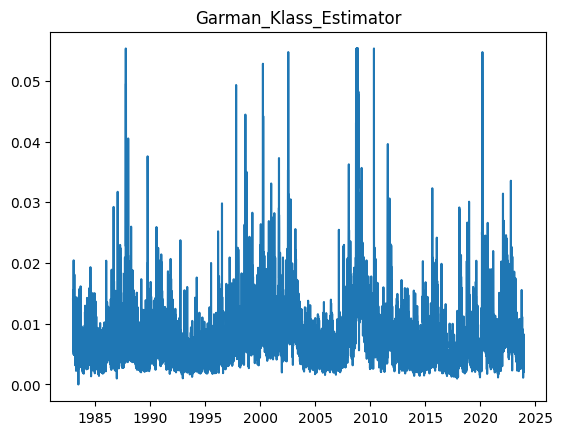

In [67]:
#CALCULATE GARMAN KLASS FOR EACH DAY

# Download S&P 500 data from Yahoo Finance
sp500 = yf.download('^GSPC', start='1983-01-01', end='2023-12-31')

# Calculate Garman-Klass estimator for each day
def calculate_gk_estimator(high, low, open_price, close):
    log_hl = np.log(high / low)
    log_co = np.log(close / open_price)
    log_co_square = log_co ** 2
    return np.sqrt((1 / (2)) * np.sum(log_hl ** 2 - (2 * np.log(2) - 1) * log_co_square))

# Create an empty list to store daily estimators
gk_estimators = []

# Iterate through the dataset day by day
for i in range(len(sp500)):
    high = sp500['High'].iloc[i]
    low = sp500['Low'].iloc[i]
    open_price = sp500['Open'].iloc[i]
    close = sp500['Close'].iloc[i]

    # Calculate the Garman-Klass estimator for the current day
    gk_est = calculate_gk_estimator(high, low, open_price, close)
    gk_estimators.append(gk_est)

# Add the daily estimators to the DataFrame
sp500['Garman_Klass_Estimator'] = gk_estimators

#Cap Extreme Vols
percentile_999 = sp500['Garman_Klass_Estimator'].quantile(0.999)
# Replace values above the 99.9th percentile with the percentile value in the DataFrame
sp500.loc[sp500['Garman_Klass_Estimator'] > percentile_999, 'Garman_Klass_Estimator'] = percentile_999

#99.9 % values of Garman Klass Estimators
percentile_999

# Displaying the DataFrame with the Garman-Klass estimator for each day
print(sp500[['Open', 'High', 'Low', 'Close', 'Garman_Klass_Estimator']])
plt.plot(sp500['Garman_Klass_Estimator'])
plt.title('Garman_Klass_Estimator')


In [68]:
#ADD TRADING_DAY COLUMN
# Add a column labeling each trading day from 1 to 252
sp500['Year'] = sp500.index.year

# Calculate the total number of trading days in each year
total_trading_days = sp500.groupby('Year').size()

# Add a column labeling each trading day from 1 to 252 and divide by the total trading days in that year
sp500['Trading_Day'] = sp500.groupby('Year').cumcount() + 1

# Get today's date
current_date = datetime.now()

# Define the start and end dates for the current year
start_date = pd.Timestamp(datetime(current_date.year, 1, 1))  # January 1st of the current year
end_date = pd.Timestamp(datetime(current_date.year, 12, 31))  # December 31st of the current year

# Generate a date range from today until the end of the year (excluding weekends and holidays)
date_range = pd.date_range(start=current_date, end=end_date, freq=BDay())

# Calculate the remaining trading days in the year
remaining_trading_days = len(date_range)

# Create a function to divide Trading_Day by the total trading days of its year
def calculate_trading_day_ratio(row):
    year = row['Year']
    if year < current_date.year:
        return row['Trading_Day'] / total_trading_days[year]
    else: 
        return row['Trading_Day'] / (total_trading_days[year]+remaining_trading_days)

# Apply the function to create Trading_Day_Ratio column
sp500['Trading_Day_Ratio'] = sp500.apply(calculate_trading_day_ratio, axis=1)


In [125]:

def calculate_trading_days(row):
    year = row['Year']
    return total_trading_days[year]
sp500['Total_Trading_Days'] = sp500.apply(calculate_trading_days, axis=1)

,Open,High,Low,Close,Adj Close,Volume,Garman_Klass_Estimator,Year,Trading_Day,Trading_Day_Ratio,Quarter_End,Days_After_Quarter_End,Seasonal_Trading,3_Day_Average,3_day_vol,Rolling_Average,Total_Trading_Days
Date,,,,,,,,,,,,,,,,,
1983-01-03,140.649994,141.330002,138.199997,138.339996,138.339996,59080000,0.014065,1983,1,0.003953,1982-12-31,3,0,0.009981,NaN,NaN,253
1983-01-04,138.330002,141.360001,138.080002,141.360001,141.360001,75530000,0.013598,1983,2,0.007905,1982-12-31,4,0,0.010164,NaN,NaN,253
1983-01-05,141.350006,142.600006,141.149994,141.960007,141.960007,95390000,0.006975,1983,3,0.011858,1982-12-31,5,0,0.009284,0.011546,NaN,253
1983-01-06,142.009995,145.770004,142.009995,145.270004,145.270004,129410000,0.015555,1983,4,0.015810,1982-12-31,6,0,0.008906,0.012042,0.014065,253
1983-01-07,145.270004,146.460007,145.149994,145.179993,145.179993,127290000,0.006347,1983,5,0.019763,1982-12-31,7,0,0.008221,0.009626,0.013831,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-14,4721.040039,4738.569824,4694.339844,4719.549805,4719.549805,6314040000,0.006630,2023,240,0.956175,2023-09-29,76,0,0.007542,0.006603,0.004021,244
2023-12-15,4714.229980,4725.529785,4704.689941,4719.189941,4719.189941,8218980000,0.003091,2023,241,0.960159,2023-09-29,77,0,0.007659,0.005994,0.004451,244
2023-12-18,4725.580078,4749.520020,4725.580078,4740.560059,4740.560059,4060340000,0.003291,2023,242,0.964143,2023-09-29,80,0,0.007575,0.004337,0.005639,244


In [69]:
#ADD QUARTER END COLUMN
sp500['Quarter_End'] = sp500.index - pd.offsets.BQuarterEnd()
#quarter_ends = sp500.groupby(sp500['Quarter_End'].dt.to_period('Q'))['Date'].max()

# Calculate the difference between 'Date' and 'Quarter_End' in days
sp500['Days_After_Quarter_End'] = (sp500.index - sp500['Quarter_End']).dt.days

# Create 'Seasonal_Trading' column based on the condition (25-31 days after Quarter End)
sp500['Seasonal_Trading'] = 0  # Initialize with 0
sp500.loc[(sp500['Days_After_Quarter_End'] >= 25) & (sp500['Days_After_Quarter_End'] <= 31), 'Seasonal_Trading'] = 1



In [70]:
sp500[sp500['Seasonal_Trading'] == 1] 

,Open,High,Low,Close,Adj Close,Volume,Garman_Klass_Estimator,Year,Trading_Day,Trading_Day_Ratio,Quarter_End,Days_After_Quarter_End,Seasonal_Trading
Date,,,,,,,,,,,,,
1983-01-25,139.979996,141.750000,139.979996,141.750000,141.750000,79740000,0.006961,1983,17,0.067194,1982-12-31,25,1
1983-01-26,141.770004,142.160004,141.160004,141.539993,141.539993,73720000,0.004940,1983,18,0.071146,1982-12-31,26,1
1983-01-27,141.539993,144.300003,141.539993,144.270004,144.270004,88120000,0.010770,1983,19,0.075099,1982-12-31,27,1
1983-01-28,144.309998,145.470001,144.250000,144.509995,144.509995,89490000,0.005924,1983,20,0.079051,1982-12-31,28,1
1983-01-31,144.509995,145.300003,143.929993,145.300003,145.300003,67140000,0.006256,1983,21,0.083004,1982-12-31,31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,4235.790039,4259.379883,4219.430176,4247.680176,4247.680176,3821820000,0.006549,2023,204,0.812749,2023-09-29,25,1
2023-10-25,4232.419922,4232.419922,4181.419922,4186.770020,4186.770020,3869370000,0.007125,2023,205,0.816733,2023-09-29,26,1
2023-10-26,4175.990234,4183.600098,4127.899902,4137.229980,4137.229980,4277640000,0.008546,2023,206,0.820717,2023-09-29,27,1


In [142]:
# Function to calculate 3-day average for each row
def calculate_3_day_average(row):
    window_start = row['Trading_Day_Ratio'] - 3/row['Total_Trading_Days']  # Window start
    window_end = row['Trading_Day_Ratio']  # Window end
    
    # Select rows within the window and have same Year
    window_rows = sp500[(sp500['Trading_Day_Ratio'] >= window_start) & (sp500['Trading_Day_Ratio'] <= window_end) & (sp500['Year'] == row['Year'])]
    
    # Calculate the average of 'Garman_Klass_Estimator' within the window
    avg = window_rows['Garman_Klass_Estimator'].mean()
    
    return avg

def calculate_5_day_average(row):
    window_start = row['Trading_Day_Ratio'] - 5/row['Total_Trading_Days']  # Window start
    window_end = row['Trading_Day_Ratio']  # Window end
    
    # Select rows within the window and have same Year
    window_rows = sp500[(sp500['Trading_Day_Ratio'] >= window_start) & (sp500['Trading_Day_Ratio'] <= window_end) & (sp500['Year'] == row['Year'])]
    
    # Calculate the average of 'Garman_Klass_Estimator' within the window
    avg = window_rows['Garman_Klass_Estimator'].mean()
    
    return avg

def calculate_7_day_average(row):
    window_start = row['Trading_Day_Ratio'] - 7/row['Total_Trading_Days']  # Window start
    window_end = row['Trading_Day_Ratio']  # Window end
    
    # Select rows within the window and have same Year
    window_rows = sp500[(sp500['Trading_Day_Ratio'] >= window_start) & (sp500['Trading_Day_Ratio'] <= window_end) & (sp500['Year'] == row['Year'])]
    
    # Calculate the average of 'Garman_Klass_Estimator' within the window
    avg = window_rows['Garman_Klass_Estimator'].mean()
    
    return avg

# Apply the function to each row to calculate 3-day average
sp500['3_Day_Average'] = sp500.apply(calculate_3_day_average, axis=1)
# Apply the function to each row to calculate 3-day average
sp500['5_Day_Average'] = sp500.apply(calculate_5_day_average, axis=1)
# Apply the function to each row to calculate 3-day average
sp500['7_Day_Average'] = sp500.apply(calculate_7_day_average, axis=1)

,Open,High,Low,Close,Adj Close,Volume,Garman_Klass_Estimator,Year,Trading_Day,Trading_Day_Ratio,Quarter_End,Days_After_Quarter_End,Seasonal_Trading,3_Day_Average,3_day_vol,Rolling_Average,Total_Trading_Days,5_Day_Average,7_Day_Average
Date,,,,,,,,,,,,,,,,,,,
1983-01-03,140.649994,141.330002,138.199997,138.339996,138.339996,59080000,0.014065,1983,1,0.003953,1982-12-31,3,0,0.014065,NaN,NaN,253,0.014065,0.014065
1983-01-04,138.330002,141.360001,138.080002,141.360001,141.360001,75530000,0.013598,1983,2,0.007905,1982-12-31,4,0,0.013831,NaN,NaN,253,0.013831,0.013831
1983-01-05,141.350006,142.600006,141.149994,141.960007,141.960007,95390000,0.006975,1983,3,0.011858,1982-12-31,5,0,0.011546,0.011546,NaN,253,0.011546,0.011546
1983-01-06,142.009995,145.770004,142.009995,145.270004,145.270004,129410000,0.015555,1983,4,0.015810,1982-12-31,6,0,0.012548,0.012042,0.014065,253,0.012548,0.012548
1983-01-07,145.270004,146.460007,145.149994,145.179993,145.179993,127290000,0.006347,1983,5,0.019763,1982-12-31,7,0,0.009626,0.009626,0.013831,253,0.011308,0.011308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-14,4721.040039,4738.569824,4694.339844,4719.549805,4719.549805,6314040000,0.006630,2023,240,0.956175,2023-09-29,76,0,0.005887,0.006603,0.004021,244,0.005312,0.005223
2023-12-15,4714.229980,4725.529785,4704.689941,4719.189941,4719.189941,8218980000,0.003091,2023,241,0.960159,2023-09-29,77,0,0.005725,0.005994,0.004451,244,0.005223,0.005102
2023-12-18,4725.580078,4749.520020,4725.580078,4740.560059,4740.560059,4060340000,0.003291,2023,242,0.964143,2023-09-29,80,0,0.005318,0.004337,0.005639,244,0.004988,0.004782


In [131]:
window_start = sp500['Trading_Day_Ratio'][0] - 3/253  # Window start
window_end = sp500['Trading_Day_Ratio'][0] 
sp500[(sp500['Trading_Day_Ratio'] >= window_start) & (sp500['Trading_Day_Ratio'] <= window_end)]

/var/folders/hb/hkn2fwj94pv5kvw7gd30r02h0000gn/T/ipykernel_1810/356091184.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_start = sp500['Trading_Day_Ratio'][0] - 3/253  # Window start
/var/folders/hb/hkn2fwj94pv5kvw7gd30r02h0000gn/T/ipykernel_1810/356091184.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  window_end = sp500['Trading_Day_Ratio'][0]


,Open,High,Low,Close,Adj Close,Volume,Garman_Klass_Estimator,Year,Trading_Day,Trading_Day_Ratio,Quarter_End,Days_After_Quarter_End,Seasonal_Trading,3_Day_Average,3_day_vol,Rolling_Average,Total_Trading_Days
Date,,,,,,,,,,,,,,,,,
1983-01-03,140.649994,141.330002,138.199997,138.339996,138.339996,59080000,0.014065,1983,1,0.003953,1982-12-31,3,0,0.009981,NaN,NaN,253
1984-01-03,164.929993,164.929993,163.979996,164.039993,164.039993,71340000,0.003321,1984,1,0.003953,1983-12-30,4,0,0.009981,0.003154,0.003696,253
1986-01-02,211.279999,211.279999,208.929993,209.589996,209.589996,98960000,0.007078,1986,1,0.003953,1985-12-31,2,0,0.009981,0.004858,0.004671,253
1987-01-02,242.169998,246.449997,242.169998,246.449997,246.449997,91880000,0.009705,1987,1,0.003953,1986-12-31,2,0,0.009981,0.007178,0.003572,253
1988-01-04,247.100006,256.440002,247.080002,255.940002,255.940002,181810000,0.021275,1988,1,0.003953,1987-12-31,4,0,0.009981,0.012283,0.009046,253
1990-01-02,353.399994,359.690002,351.980011,359.690002,359.690002,162070000,0.013215,1990,1,0.003953,1989-12-29,4,0,0.009981,0.006879,0.003719,253
1991-01-02,330.200012,330.750000,326.450012,326.450012,326.450012,126280000,0.007773,1991,1,0.003953,1990-12-31,2,0,0.009981,0.005475,0.004516,253
1992-01-02,417.029999,417.269989,411.040009,417.260010,417.260010,207570000,0.010634,1992,1,0.003937,1991-12-31,2,0,0.009306,0.010528,0.006387,254
1993-01-04,435.700012,437.320007,434.480011,435.380005,435.380005,201210000,0.004596,1993,1,0.003953,1992-12-31,4,0,0.009981,0.004520,0.004347,253


In [76]:
# def rolling_3_day(df, end_days):
#     return df.rolling.mean(end_days)

#     for col in sp500:
    
        
#     return rolling_3_day(sp500['Garman_Klass_Estimator'], 3)



AttributeError: 'function' object has no attribute 'mean'

In [ ]:
sp500['3_day_vol'] = sp500['Garman_Klass_Estimator'].rolling(3).mean()

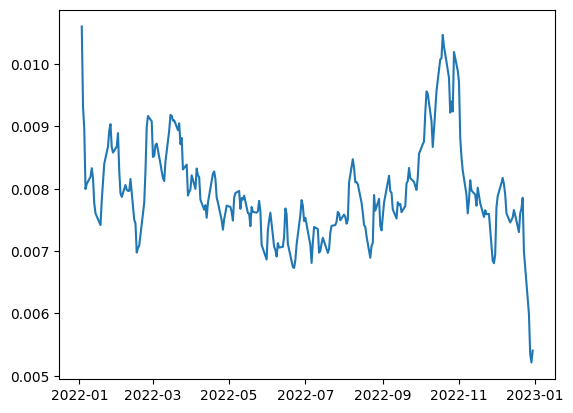

In [74]:
year_2022 = sp500[sp500['Year'] == 2022]
plt.plot(year_2022['3_Day_Average'])

In [49]:
#HAR MODEL
import statsmodels.api as sm

# Calculating different volatility measures
sp500['yesterday_volatility'] = sp500['Garman_Klass_Estimator'].shift(1)
sp500['avg_2_5_day_volatility'] = sp500['Garman_Klass_Estimator'].shift(6).rolling(window=5).mean()
sp500['avg_6_21_day_volatility'] = sp500['Garman_Klass_Estimator'].shift(21).rolling(window=16).mean()

# Dropping NaN values resulting from rolling means
data = sp500.dropna()

# Creating the HAR model
X = data[['yesterday_volatility', 'avg_2_5_day_volatility', 'avg_6_21_day_volatility', 'Seasonal_Trading']]
X = sm.add_constant(X)  # Adding a constant coefficient
y = data['Garman_Klass_Estimator']

# Fitting the model
model = sm.OLS(y, X).fit()

# Printing the model summary
print(model.summary())


                              OLS Regression Results                              
Dep. Variable:     Garman_Klass_Estimator   R-squared:                       0.499
Model:                                OLS   Adj. R-squared:                  0.499
Method:                     Least Squares   F-statistic:                     2052.
Date:                    Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                            14:36:19   Log-Likelihood:                 42369.
No. Observations:                   10291   AIC:                        -8.473e+04
Df Residuals:                       10285   BIC:                        -8.468e+04
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------